# Read Data

In [29]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('ETH_USDT_futures_data_2020.csv')

# Drop unnecessary columns
df.drop(columns=(['coin','volume','closetime','quotevolume','trades','taker_buy_volume','taker_buy_quote','unused']), inplace=True)

# Display the first few rows of the DataFrame
df

,opentime,openprice,highprice,lowprice,closeprice
0,1577836800000,129.12,129.12,128.62,128.82
1,1577840400000,128.81,130.61,128.76,130.57
2,1577844000000,130.58,130.97,130.30,130.80
3,1577847600000,130.80,130.82,129.88,130.09
4,1577851200000,130.10,130.63,130.09,130.15
...,...,...,...,...,...
43661,1735016400000,3412.22,3433.99,3406.96,3422.61
43662,1735020000000,3422.62,3425.89,3384.52,3391.88
43663,1735023600000,3391.87,3414.65,3383.49,3399.92
43664,1735027200000,3399.91,3415.41,3391.82,3411.98


# Add Super Trend Indicator

In [30]:
import pandas as pd
import numpy as np
from pandas_ta.overlap import hl2
from pandas_ta.volatility import atr
from pandas_ta.utils import get_offset, verify_series

# Apply the Supertrend function
def supertrend(high, low, close, length=7, multiplier=3.0, offset=0, **kwargs):
    """Indicator: Supertrend"""
    # Validate Arguments
    high = verify_series(high, length)
    low = verify_series(low, length)
    close = verify_series(close, length)
    offset = get_offset(offset)

    if high is None or low is None or close is None:
        return

    m = close.size
    dir_, trend = [1] * m, [0] * m
    long, short = [np.nan] * m, [np.nan] * m

    hl2_ = hl2(high, low)
    matr = multiplier * atr(high, low, close, length)
    upperband = hl2_ + matr
    lowerband = hl2_ - matr

    for i in range(1, m):
        if close.iloc[i] > upperband.iloc[i - 1]:
            dir_[i] = 1
        elif close.iloc[i] < lowerband.iloc[i - 1]:
            dir_[i] = -1
        else:
            dir_[i] = dir_[i - 1]
            if dir_[i] > 0 and lowerband.iloc[i] < lowerband.iloc[i - 1]:
                lowerband.iloc[i] = lowerband.iloc[i - 1]
            if dir_[i] < 0 and upperband.iloc[i] > upperband.iloc[i - 1]:
                upperband.iloc[i] = upperband.iloc[i - 1]

        if dir_[i] > 0:
            trend[i] = long[i] = lowerband.iloc[i]
        else:
            trend[i] = short[i] = upperband.iloc[i]

    # Prepare DataFrame to return
    _props = f"_{length}_{multiplier}"
    df = pd.DataFrame({
        f"SUPERT{_props}": trend,
        f"SUPERTd{_props}": dir_,
        f"SUPERTl{_props}": long,
        f"SUPERTs{_props}": short,
    }, index=close.index)

    df.name = f"SUPERT{_props}"
    df.category = "overlap"

    # Apply offset if needed
    if offset != 0:
        df = df.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        df.fillna(kwargs["fillna"], inplace=True)

    if "fill_method" in kwargs:
        df.fillna(method=kwargs["fill_method"], inplace=True)

    return df

In [31]:
# Get the Supertrend values using the 'highprice', 'lowprice', and 'closeprice' columns
supertrend_indicator = supertrend(df['highprice'], df['lowprice'], df['closeprice'], length=10, multiplier=3.0)

# Join the Supertrend indicator values to your original dataframe
supertrend_df = df.join(supertrend_indicator)

# Drop unnecessary columns
supertrend_df.drop(columns=(['SUPERT_10_3.0','SUPERTd_10_3.0']), inplace=True)

# Check the output
supertrend_df

,opentime,openprice,highprice,lowprice,closeprice,SUPERTl_10_3.0,SUPERTs_10_3.0
0,1577836800000,129.12,129.12,128.62,128.82,NaN,NaN
1,1577840400000,128.81,130.61,128.76,130.57,NaN,NaN
2,1577844000000,130.58,130.97,130.30,130.80,NaN,NaN
3,1577847600000,130.80,130.82,129.88,130.09,NaN,NaN
4,1577851200000,130.10,130.63,130.09,130.15,NaN,NaN
...,...,...,...,...,...,...,...
43661,1735016400000,3412.22,3433.99,3406.96,3422.61,3287.806533,NaN
43662,1735020000000,3422.62,3425.89,3384.52,3391.88,3287.806533,NaN
43663,1735023600000,3391.87,3414.65,3383.49,3399.92,3287.806533,NaN
43664,1735027200000,3399.91,3415.41,3391.82,3411.98,3287.806533,NaN


In [40]:
# supertrend_df_sample = supertrend_df.tail(200)
# supertrend_df_sample

C:\Users\user\AppData\Local\Temp\ipykernel_1804\2415016074.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supertrend_df_sample['opentime'] = pd.to_datetime(supertrend_df_sample['opentime'], unit='ms')
C:\Users\user\AppData\Local\Temp\ipykernel_1804\2415016074.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supertrend_df_sample['date_num'] = mdates.date2num(supertrend_df_sample['opentime'])


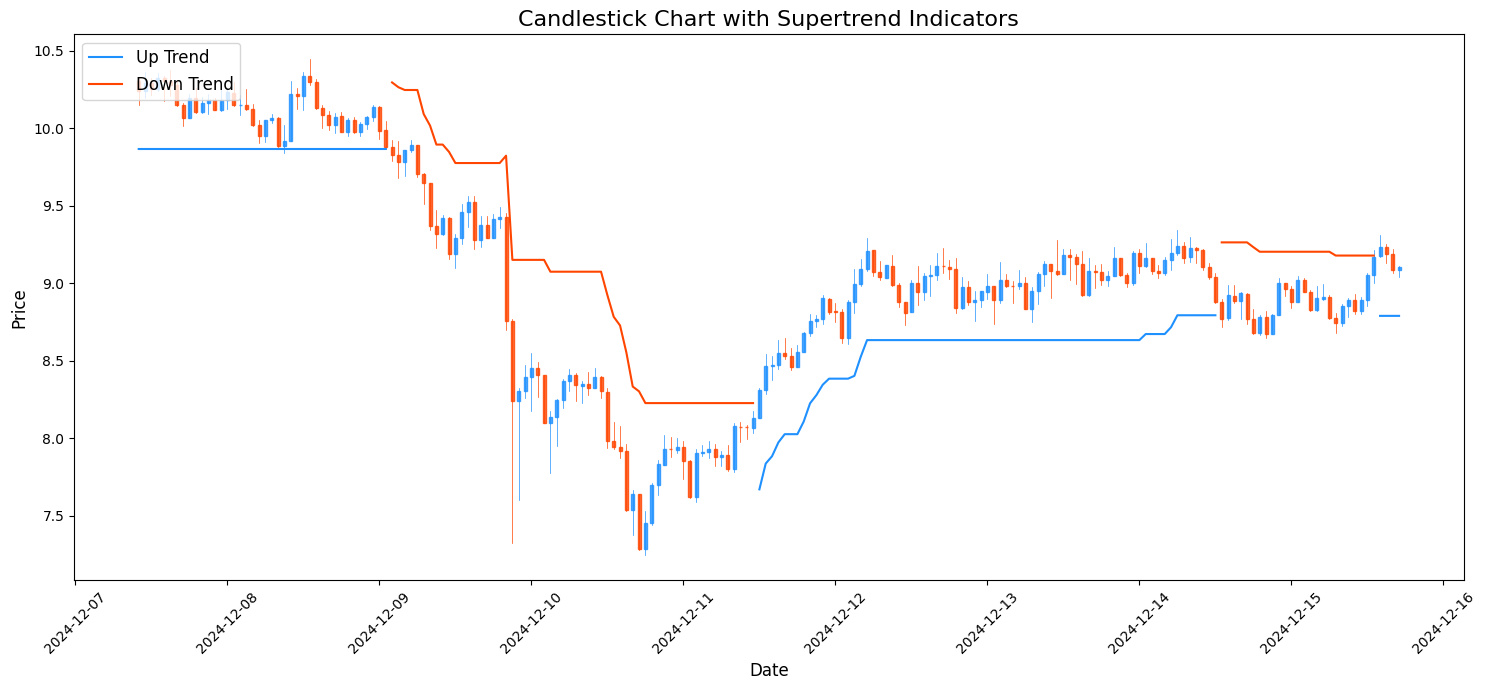

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from mplfinance.original_flavor import candlestick_ohlc
# import matplotlib.dates as mdates

# # Assuming `supertrend_df` is already loaded
# # Convert 'opentime' to datetime and set up plotting data
# supertrend_df_sample['opentime'] = pd.to_datetime(supertrend_df_sample['opentime'], unit='ms')
# supertrend_df_sample['date_num'] = mdates.date2num(supertrend_df_sample['opentime'])

# # Prepare OHLC data for candlestick plot
# ohlc = supertrend_df_sample[['date_num', 'openprice', 'highprice', 'lowprice', 'closeprice']].dropna().values

# # Plot configuration
# fig, ax = plt.subplots(figsize=(15, 7))
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.xticks(rotation=45)
# plt.title('Candlestick Chart with Supertrend Indicators', fontsize=16)
# plt.xlabel('Date', fontsize=12)
# plt.ylabel('Price', fontsize=12)

# # Plot candlestick chart
# candlestick_ohlc(ax, ohlc, width=0.02, colorup='dodgerblue', colordown='orangered', alpha=0.8)

# # Plot SUPERTl_10_3.0 (green) and SUPERTs_10_3.0 (red)
# ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTl_10_3.0'], color='dodgerblue', label='Up Trend')
# ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTs_10_3.0'], color='orangered', label='Down Trend')

# # Add legend
# plt.legend(loc='upper left', fontsize=12)
# plt.tight_layout()
# plt.show()


# Add Ichimoku Cloud Indicator

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the Ichimoku Cloud function
def ichimoku_cloud(data, conversion_periods=9, base_periods=26, span_b_periods=52, displacement=26):
    """
    Compute Ichimoku Cloud components:
    - Conversion Line (Tenkan-sen)
    - Base Line (Kijun-sen)
    - Leading Span A (Senkou Span A)
    - Leading Span B (Senkou Span B)
    - Lagging Span (Chikou Span)
    """
    # Helper to calculate the average of the highest high and lowest low
    def donchian(data, period):
        return (data['highprice'].rolling(window=period).max() + 
                data['lowprice'].rolling(window=period).min()) / 2

    # Compute Ichimoku Cloud components
    data['conversion_line'] = donchian(data, conversion_periods)
    data['base_line'] = donchian(data, base_periods)
    data['leading_span_a'] = ((data['conversion_line'] + data['base_line']) / 2).shift(displacement)
    data['leading_span_b'] = donchian(data, span_b_periods).shift(displacement)
    data['lagging_span'] = data['closeprice'].shift(-displacement)

    return data

In [33]:
# Apply Ichimoku Cloud computation
supertrend_ichimoku_df = ichimoku_cloud(supertrend_df)

supertrend_ichimoku_df.drop(columns=(['conversion_line','base_line','lagging_span']), inplace=True)

supertrend_ichimoku_df

,opentime,openprice,highprice,lowprice,closeprice,SUPERTl_10_3.0,SUPERTs_10_3.0,leading_span_a,leading_span_b
0,1577836800000,129.12,129.12,128.62,128.82,NaN,NaN,NaN,NaN
1,1577840400000,128.81,130.61,128.76,130.57,NaN,NaN,NaN,NaN
2,1577844000000,130.58,130.97,130.30,130.80,NaN,NaN,NaN,NaN
3,1577847600000,130.80,130.82,129.88,130.09,NaN,NaN,NaN,NaN
4,1577851200000,130.10,130.63,130.09,130.15,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
43661,1735016400000,3412.22,3433.99,3406.96,3422.61,3287.806533,NaN,3296.8525,3384.285
43662,1735020000000,3422.62,3425.89,3384.52,3391.88,3287.806533,NaN,3298.5950,3384.285
43663,1735023600000,3391.87,3414.65,3383.49,3399.92,3287.806533,NaN,3298.5950,3384.285
43664,1735027200000,3399.91,3415.41,3391.82,3411.98,3287.806533,NaN,3298.5950,3384.285


In [33]:
# # Apply Ichimoku Cloud computation
# supertrend_ichimoku_df_sample = ichimoku_cloud(supertrend_df_sample)

# supertrend_ichimoku_df_sample.drop(columns=(['date_num','conversion_line','base_line','lagging_span']), inplace=True)

# supertrend_ichimoku_df_sample

C:\Users\user\AppData\Local\Temp\ipykernel_1804\2269044917.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['conversion_line'] = donchian(data, conversion_periods)
C:\Users\user\AppData\Local\Temp\ipykernel_1804\2269044917.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['base_line'] = donchian(data, base_periods)
C:\Users\user\AppData\Local\Temp\ipykernel_1804\2269044917.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,opentime,openprice,highprice,lowprice,closeprice,SUPERTl_10_3.0,SUPERTs_10_3.0,leading_span_a,leading_span_b
42358,2024-12-07 10:00:00,10.303,10.325,10.150,10.241,9.866172,NaN,NaN,NaN
42359,2024-12-07 11:00:00,10.239,10.363,10.195,10.293,9.866172,NaN,NaN,NaN
42360,2024-12-07 12:00:00,10.293,10.327,10.214,10.255,9.866172,NaN,NaN,NaN
42361,2024-12-07 13:00:00,10.254,10.354,10.240,10.323,9.866172,NaN,NaN,NaN
42362,2024-12-07 14:00:00,10.322,10.335,10.177,10.304,9.866172,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
42553,2024-12-15 13:00:00,9.054,9.212,9.000,9.172,NaN,9.178569,9.1555,9.038
42554,2024-12-15 14:00:00,9.173,9.308,9.172,9.233,8.789368,NaN,9.1075,9.038
42555,2024-12-15 15:00:00,9.233,9.255,9.133,9.190,8.789368,NaN,9.0320,9.032
42556,2024-12-15 16:00:00,9.190,9.223,9.068,9.088,8.789368,NaN,9.0320,9.032


C:\Users\user\AppData\Local\Temp\ipykernel_1804\970262829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supertrend_ichimoku_df_sample['opentime'] = pd.to_datetime(supertrend_ichimoku_df_sample['opentime'], unit='ms')
C:\Users\user\AppData\Local\Temp\ipykernel_1804\970262829.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supertrend_ichimoku_df_sample['date_num'] = mdates.date2num(supertrend_ichimoku_df_sample['opentime'])


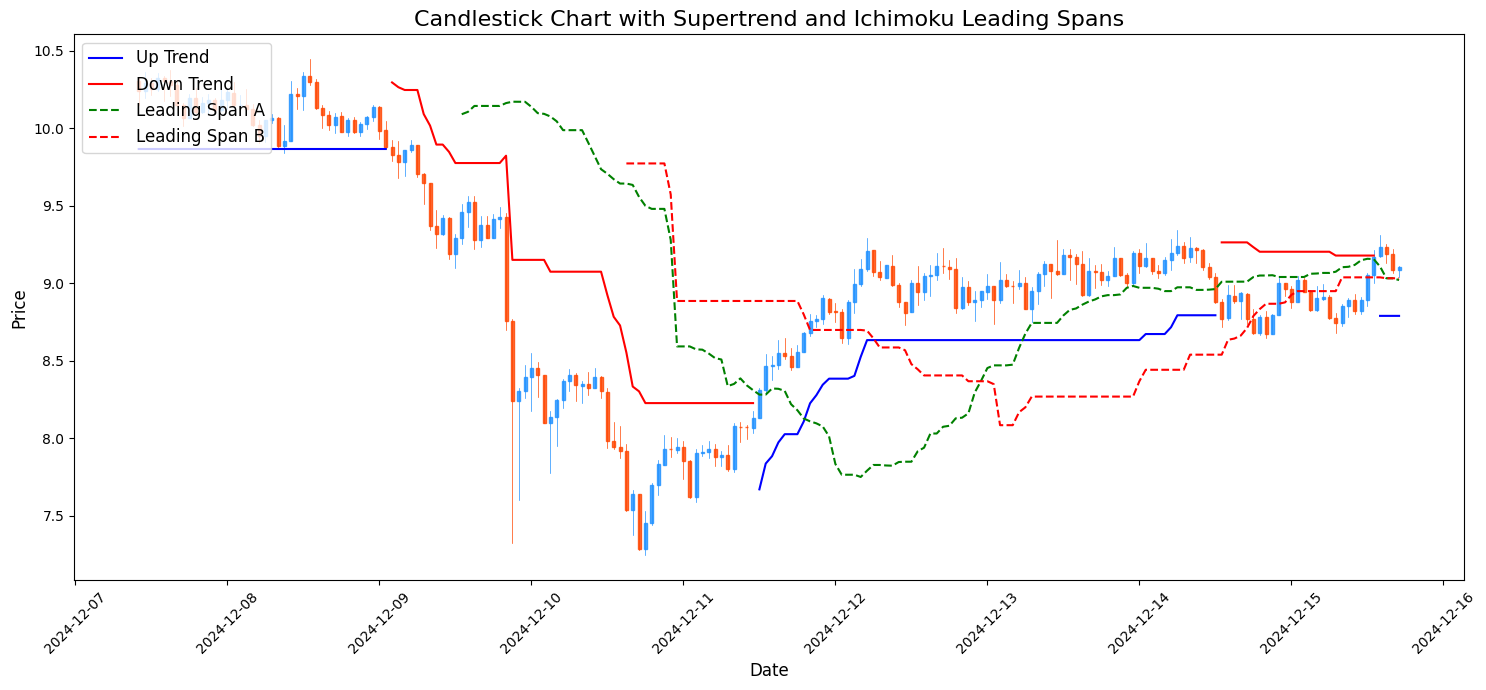

In [37]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from mplfinance.original_flavor import candlestick_ohlc
# import matplotlib.dates as mdates

# # Assuming `supertrend_ichimoku_df_sample` is already loaded
# # Convert 'opentime' to datetime and set up plotting data
# supertrend_ichimoku_df_sample['opentime'] = pd.to_datetime(supertrend_ichimoku_df_sample['opentime'], unit='ms')
# supertrend_ichimoku_df_sample['date_num'] = mdates.date2num(supertrend_ichimoku_df_sample['opentime'])

# # Prepare OHLC data for candlestick plot
# ohlc = supertrend_ichimoku_df_sample[['date_num', 'openprice', 'highprice', 'lowprice', 'closeprice']].dropna().values

# # Plot configuration
# fig, ax = plt.subplots(figsize=(15, 7))
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.xticks(rotation=45)
# plt.title('Candlestick Chart with Supertrend and Ichimoku Leading Spans', fontsize=16)
# plt.xlabel('Date', fontsize=12)
# plt.ylabel('Price', fontsize=12)

# # Plot candlestick chart
# candlestick_ohlc(ax, ohlc, width=0.02, colorup='dodgerblue', colordown='orangered', alpha=0.8)

# # Plot Supertrend Uptrend and Downtrend
# ax.plot(supertrend_ichimoku_df_sample['date_num'], supertrend_ichimoku_df_sample['SUPERTl_10_3.0'], color='blue', label='Up Trend')
# ax.plot(supertrend_ichimoku_df_sample['date_num'], supertrend_ichimoku_df_sample['SUPERTs_10_3.0'], color='red', label='Down Trend')

# # Plot Leading Span A and Leading Span B
# ax.plot(supertrend_ichimoku_df_sample['date_num'], supertrend_ichimoku_df_sample['leading_span_a'], color='green', linestyle='--', label='Leading Span A')
# ax.plot(supertrend_ichimoku_df_sample['date_num'], supertrend_ichimoku_df_sample['leading_span_b'], color='red', linestyle='--', label='Leading Span B')

# # Add legend
# plt.legend(loc='upper left', fontsize=12)
# plt.tight_layout()
# plt.show()

# Backtest Signaling

In [34]:
df_backtest = supertrend_ichimoku_df.copy()

# Rename the last 4 columns
new_column_names = {
    'opentime': 'time',
    'openprice': 'open',
    'highprice': 'high',
    'lowprice': 'low',
    'closeprice': 'close',
    'SUPERTl_10_3.0': 'Up Trend',
    'SUPERTs_10_3.0': 'Down Trend',
    'leading_span_a': 'Leading Span A',
    'leading_span_b': 'Leading Span B',
}
df_backtest.rename(columns=new_column_names, inplace=True)

# Drop rows 0 to 50 becuase the cloud has a 50 row lags
df_backtest.drop(index=range(51), inplace=True)

df_backtest.reset_index(drop=True,inplace=True)

df_backtest

,time,open,high,low,close,Up Trend,Down Trend,Leading Span A,Leading Span B
0,1578020400000,126.90,127.00,126.59,126.76,NaN,129.001617,131.0200,NaN
1,1578024000000,126.81,130.18,126.81,129.23,125.186485,NaN,130.7400,NaN
2,1578027600000,129.23,129.95,128.69,129.18,125.964159,NaN,130.6775,NaN
3,1578031200000,129.18,129.31,128.75,129.16,125.964159,NaN,130.6375,NaN
4,1578034800000,129.15,129.43,128.69,128.82,125.969376,NaN,130.6375,NaN
...,...,...,...,...,...,...,...,...,...
43610,1735016400000,3412.22,3433.99,3406.96,3422.61,3287.806533,NaN,3296.8525,3384.285
43611,1735020000000,3422.62,3425.89,3384.52,3391.88,3287.806533,NaN,3298.5950,3384.285
43612,1735023600000,3391.87,3414.65,3383.49,3399.92,3287.806533,NaN,3298.5950,3384.285
43613,1735027200000,3399.91,3415.41,3391.82,3411.98,3287.806533,NaN,3298.5950,3384.285


In [35]:
import numpy as np

# Set 'super_trend' to 1 if 'Down Trend' is NaN, and to 0 if 'Up Trend' is NaN
df_backtest['super_trend'] = np.where(df_backtest['Down Trend'].isna(), 1, 
                                      np.where(df_backtest['Up Trend'].isna(), -1, np.nan))

# Define a function to determine the action suggestion for each row
def determine_criteria_pass(row):
    if row['super_trend'] == 1 and row['open'] > max(row['Leading Span A'], row['Leading Span B']):
        return 1
    elif row['super_trend'] == -1 and row['open'] < min(row['Leading Span A'], row['Leading Span B']):
        return 1
    return 0

# Apply the function row-wise to the DataFrame
df_backtest['criteria'] = df_backtest.apply(determine_criteria_pass, axis=1)

# Initialize 'action' column to None
df_backtest['action'] = None

# Assign 'long' where super_trend == 1 and criteria == 1
df_backtest['action'] = np.where(
    (df_backtest['super_trend'] == 1) & (df_backtest['criteria'] == 1),
    'long',
    df_backtest['action']
)

# Assign 'short' where super_trend == -1 and criteria == 1
df_backtest['action'] = np.where(
    (df_backtest['super_trend'] == -1) & (df_backtest['criteria'] == 1),
    'short',
    df_backtest['action']
)

# Assign 'close' where super_trend changes (shifted value not equal to current value)
df_backtest['trend_change'] = np.where(
    df_backtest['super_trend'].shift(1) != df_backtest['super_trend'],
    1,
    0
)

df_backtest['time'] = (df_backtest['time']/1000).astype(int)

df_backtest

,time,open,high,low,close,Up Trend,Down Trend,Leading Span A,Leading Span B,super_trend,criteria,action,trend_change
0,1578020400,126.90,127.00,126.59,126.76,NaN,129.001617,131.0200,NaN,-1.0,1,short,1
1,1578024000,126.81,130.18,126.81,129.23,125.186485,NaN,130.7400,NaN,1.0,0,None,1
2,1578027600,129.23,129.95,128.69,129.18,125.964159,NaN,130.6775,NaN,1.0,0,None,0
3,1578031200,129.18,129.31,128.75,129.16,125.964159,NaN,130.6375,NaN,1.0,0,None,0
4,1578034800,129.15,129.43,128.69,128.82,125.969376,NaN,130.6375,NaN,1.0,0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43610,1735016400,3412.22,3433.99,3406.96,3422.61,3287.806533,NaN,3296.8525,3384.285,1.0,1,long,0
43611,1735020000,3422.62,3425.89,3384.52,3391.88,3287.806533,NaN,3298.5950,3384.285,1.0,1,long,0
43612,1735023600,3391.87,3414.65,3383.49,3399.92,3287.806533,NaN,3298.5950,3384.285,1.0,1,long,0
43613,1735027200,3399.91,3415.41,3391.82,3411.98,3287.806533,NaN,3298.5950,3384.285,1.0,1,long,0


In [36]:
# Get the backtest trade history
df_action_close = df_backtest[df_backtest['trend_change'] == 1]

# Generate consecutive row index pairs
index_list = df_action_close.index.tolist()
consecutive_pairs = [(index_list[i], index_list[i + 1]) for i in range(len(index_list) - 1)]

consecutive_pairs

# Create a function to process each pair
def process_consecutive_pairs(df_backtest, consecutive_pairs):
    result_pairs = []

    for start_idx, end_idx in consecutive_pairs:
        # Slice the dataframe between the two indices (inclusive)
        sub_df = df_backtest.iloc[start_idx:end_idx+1]
        
        # Check if there is any "short" or "long" action in the 'action' column
        actions = sub_df['action']
        long_short_indices = actions[actions.isin(['long', 'short'])]

        if not long_short_indices.empty:
            # Note the first occurrence nearest to the first index of the pair
            first_action_idx = long_short_indices.index[0]
            # Add the result as a tuple (first action index, second close index)
            result_pairs.append((first_action_idx, end_idx))

    return result_pairs

# Call the function with your DataFrame and consecutive_pairs
result = process_consecutive_pairs(df_backtest, consecutive_pairs)

# Function to drop pairs where both indices are the same
def remove_duplicate_indices(pairs):
    return [(start_idx, end_idx) for start_idx, end_idx in pairs if start_idx != end_idx]

# Apply the function to the result list
filtered_result = remove_duplicate_indices(result)

# Create the result DataFrame
results = []
for start_idx, end_idx in filtered_result:
    position = df_backtest.loc[start_idx, 'action']
    open_time = df_backtest.loc[start_idx, 'time']
    open_price = df_backtest.loc[start_idx, 'open']
    exit_time = df_backtest.loc[end_idx, 'time']
    exit_price = df_backtest.loc[end_idx, 'close']
    
    # Slice the DataFrame between start_idx and end_idx (inclusive)
    sub_df = df_backtest.iloc[start_idx:end_idx + 1]
    min_price = sub_df['low'].min()
    max_price = sub_df['high'].max()
    
    results.append({
        "position": position,
        "open_time": open_time,
        "open_price": open_price,
        "exit_time": exit_time,
        "exit_price": exit_price,
        "min_price": min_price,
        "max_price": max_price
    })

backtest_trade_recap = pd.DataFrame(results)

# Display the recap DataFrame
backtest_trade_recap

,position,open_time,open_price,exit_time,exit_price,min_price,max_price
0,short,1578020400,126.90,1578024000,129.23,126.59,130.18
1,long,1578042000,132.12,1578409200,139.46,130.94,145.25
2,long,1578427200,143.18,1578499200,138.90,137.95,147.94
3,short,1578502800,138.96,1578657600,139.76,135.22,141.52
4,long,1578679200,141.96,1579431600,166.87,141.49,179.57
...,...,...,...,...,...,...,...
807,long,1733929200,3769.24,1734199200,3832.46,3752.48,3986.94
808,short,1734202800,3832.46,1734303600,3958.50,3822.37,3973.67
809,long,1734307200,3958.50,1734458400,3929.56,3882.22,4109.99
810,short,1734462000,3929.57,1734714000,3435.98,3100.00,3953.40


# Back Test Simulation

In [37]:
import numpy as np
import pandas as pd

# Copy the backtest_trade_recap DataFrame
backtest_trade_sim = backtest_trade_recap.copy()

# Initialize columns
backtest_trade_sim['quantity'] = 1000  # Base quantity per trade
backtest_trade_sim['leverage'] = 1    # Default leverage (e.g., 10x)
backtest_trade_sim['open_fee'] = 0
backtest_trade_sim['exit_fee'] = 0
backtest_trade_sim['realized_pnl'] = 0
backtest_trade_sim['max_drawdown_percent'] = 0  # Column for max drawdown % calculation

# Define the taker fee and funding rate
taker_fee = 0.0005  # 0.05% futures
funding_rate = 0.0001  # 0.01%

# Adjust quantity based on leverage
backtest_trade_sim['leveraged_quantity'] = backtest_trade_sim['quantity'] * backtest_trade_sim['leverage']

# Calculate open_fee
backtest_trade_sim['open_fee'] = backtest_trade_sim['leveraged_quantity'] * taker_fee

# Calculate exit_fee
backtest_trade_sim['exit_fee'] = (
    (backtest_trade_sim['leveraged_quantity'] / backtest_trade_sim['open_price']) * 
    backtest_trade_sim['exit_price'] * taker_fee
)

# Calculate position hold time
backtest_trade_sim['hold_time'] = (backtest_trade_sim['exit_time'] - backtest_trade_sim['open_time']) / 3600

# Calculate funding_fee occurrences and total funding_fee
backtest_trade_sim['funding_fee_occurence'] = backtest_trade_sim['hold_time'] // 8
backtest_trade_sim['funding_fee'] = (
    backtest_trade_sim['leveraged_quantity'] * backtest_trade_sim['funding_fee_occurence'] * funding_rate
)

# Calculate max drawdown (in %), accounting for leverage
def calculate_max_drawdown(row):
    if row['position'] == 'long':
        # For Long, calculate max drawdown from open price to min price
        max_drawdown = (row['min_price'] - row['open_price']) / row['open_price'] * 100
    elif row['position'] == 'short':
        # For Short, calculate max drawdown from open price to max price
        max_drawdown = (row['open_price'] - row['max_price']) / row['open_price'] * 100
    else:
        return 0  # Default case, should not be reached
    
    # Include leverage to magnify the effect of drawdown
    max_drawdown_leverage = max_drawdown * row['leverage']  # Leverage magnifies the drawdown
    
    return max_drawdown_leverage

backtest_trade_sim['max_drawdown_percent'] = backtest_trade_sim.apply(calculate_max_drawdown, axis=1)

# Calculate realized_pnl
def calculate_realized_pnl(row):
    position = row['position']
    leveraged_quantity = row['leveraged_quantity']
    open_price = row['open_price']
    exit_price = row['exit_price']
    open_fee = row['open_fee']
    exit_fee = row['exit_fee']
    funding_fee = row['funding_fee']
    
    if position == 'short':
        return leveraged_quantity - (leveraged_quantity / open_price * exit_price) - open_fee - exit_fee - funding_fee
    elif position == 'long':
        return (leveraged_quantity / open_price * exit_price) - leveraged_quantity - open_fee - exit_fee - funding_fee
    return 0  # Default case, should not be reached

backtest_trade_sim['realized_pnl'] = backtest_trade_sim.apply(calculate_realized_pnl, axis=1)

# Calculate cumulative realized profit and loss
backtest_trade_sim['cumulative_realized_pnl'] = backtest_trade_sim['realized_pnl'].cumsum()

# Define trade win/loss
backtest_trade_sim['win_loss'] = np.where(backtest_trade_sim['realized_pnl'] >= 0, 'Win', 'Lose')

# Display specific columns
backtest_trade_sim[['position', 'open_time', 'open_price', 'exit_time', 'exit_price', 'min_price', 'max_price', 
                          'realized_pnl', 'max_drawdown_percent', 'leveraged_quantity', 'cumulative_realized_pnl', 'win_loss']]

,position,open_time,open_price,exit_time,exit_price,min_price,max_price,realized_pnl,max_drawdown_percent,leveraged_quantity,cumulative_realized_pnl,win_loss
0,short,1578020400,126.90,1578024000,129.23,126.59,130.18,-19.370095,-2.584712,1000,-19.370095,Lose
1,long,1578042000,132.12,1578409200,139.46,130.94,145.25,53.327778,-0.893127,1000,33.957683,Win
2,long,1578427200,143.18,1578499200,138.90,137.95,147.94,-31.077497,-3.652745,1000,2.880186,Lose
3,short,1578502800,138.96,1578657600,139.76,135.22,141.52,-7.259931,-1.842257,1000,-4.379745,Lose
4,long,1578679200,141.96,1579431600,166.87,141.49,179.57,171.784228,-0.331079,1000,167.404483,Win
...,...,...,...,...,...,...,...,...,...,...,...,...
807,long,1733929200,3769.24,1734199200,3832.46,3752.48,3986.94,14.864226,-0.444652,1000,4938.049147,Win
808,short,1734202800,3832.46,1734303600,3958.50,3822.37,3973.67,-34.203936,-3.684579,1000,4903.845211,Lose
809,long,1734307200,3958.50,1734458400,3929.56,3882.22,4109.99,-8.807195,-1.926993,1000,4895.038016,Lose
810,short,1734462000,3929.57,1734714000,3435.98,3100.00,3953.40,123.871968,-0.606428,1000,5018.909984,Win


## Static Balance

In [38]:
# Calculate trade simulation
backtest_trade_sim = backtest_trade_recap.copy()

backtest_trade_sim['balance'] = 1000
backtest_trade_sim['open_fee'] = 0
backtest_trade_sim['exit_fee'] = 0
backtest_trade_sim['realized_pnl'] = 0

# Define the taker fee (e.g., 0.001 for 0.1%)
taker_fee = 0.0005 # 0.05% futures
# taker_fee = 0.001 # 0.1% spot

# Define Funding rate
funding_rate = 0.0001 #0.01%

# Calculate open_fee
backtest_trade_sim['open_fee'] = backtest_trade_sim['balance'] * taker_fee

# Calculate exit_fee
backtest_trade_sim['exit_fee'] = (
    (backtest_trade_sim['balance'] / backtest_trade_sim['open_price']) * 
    backtest_trade_sim['exit_price'] * taker_fee
)

# Calculate position hold time
backtest_trade_sim['hold_time'] = (backtest_trade_sim['exit_time'] - backtest_trade_sim['open_time']) / 3600

# Calculate how many times it need to pay funding_fee
backtest_trade_sim['funding_fee_occurence'] = backtest_trade_sim['hold_time'] // 8

# Calculate funding_fee
backtest_trade_sim['funding_fee'] = backtest_trade_sim['balance'] * backtest_trade_sim['funding_fee_occurence'] * funding_rate

# Calculate realized_pnl
def calculate_realized_pnl(row):
    position = row['position']
    balance = row['balance']
    open_price = row['open_price']
    exit_price = row['exit_price']
    open_fee = row['open_fee']
    exit_fee = row['exit_fee']
    funding_fee = row['funding_fee']
    
    if position == 'short':
        return balance - (balance / open_price * exit_price) - open_fee - exit_fee - funding_fee
    elif position == 'long':
        return (balance / open_price * exit_price) - balance - open_fee - exit_fee - funding_fee
    return 0  # Default case, should not be reached

backtest_trade_sim['realized_pnl'] = backtest_trade_sim.apply(calculate_realized_pnl, axis=1)

# Calculate cumulative realized profit and loss
backtest_trade_sim['cumulative_realized_pnl'] = backtest_trade_sim['realized_pnl'].cumsum()

# Define trade win/loss
backtest_trade_sim['win_loss'] = np.where(backtest_trade_sim['realized_pnl'] >= 0, 'Win', 'Lose')

# Display the updated DataFrame
backtest_trade_sim

,position,open_time,open_price,exit_time,exit_price,min_price,max_price,balance,open_fee,exit_fee,realized_pnl,hold_time,funding_fee_occurence,funding_fee,cumulative_realized_pnl,win_loss
0,short,1578020400,126.90,1578024000,129.23,126.59,130.18,1000,0.5,0.509180,-19.370095,1.0,0.0,0.0,-19.370095,Lose
1,long,1578042000,132.12,1578409200,139.46,130.94,145.25,1000,0.5,0.527778,53.327778,102.0,12.0,1.2,33.957683,Win
2,long,1578427200,143.18,1578499200,138.90,137.95,147.94,1000,0.5,0.485054,-31.077497,20.0,2.0,0.2,2.880186,Lose
3,short,1578502800,138.96,1578657600,139.76,135.22,141.52,1000,0.5,0.502879,-7.259931,43.0,5.0,0.5,-4.379745,Lose
4,long,1578679200,141.96,1579431600,166.87,141.49,179.57,1000,0.5,0.587736,171.784228,209.0,26.0,2.6,167.404483,Win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,long,1733929200,3769.24,1734199200,3832.46,3752.48,3986.94,1000,0.5,0.508386,14.864226,75.0,9.0,0.9,4938.049147,Win
808,short,1734202800,3832.46,1734303600,3958.50,3822.37,3973.67,1000,0.5,0.516444,-34.203936,28.0,3.0,0.3,4903.845211,Lose
809,long,1734307200,3958.50,1734458400,3929.56,3882.22,4109.99,1000,0.5,0.496345,-8.807195,42.0,5.0,0.5,4895.038016,Lose
810,short,1734462000,3929.57,1734714000,3435.98,3100.00,3953.40,1000,0.5,0.437195,123.871968,70.0,8.0,0.8,5018.909984,Win


In [39]:
import pandas as pd

# Count of positions (number and percentage)
position_counts = backtest_trade_sim['position'].value_counts()
position_percentages = position_counts / len(backtest_trade_sim) * 100

# Realized PnL statistics
realized_pnl_stats = {
    'max': backtest_trade_sim['realized_pnl'].max(),
    'min': backtest_trade_sim['realized_pnl'].min(),
    'avg': backtest_trade_sim['realized_pnl'].mean(),
    'median': backtest_trade_sim['realized_pnl'].median(),
}

# Win rate (overall)
total_trades = len(backtest_trade_sim)
wins = (backtest_trade_sim['realized_pnl'] >= 0).sum()
win_rate = wins / total_trades * 100

# Win rate per position (long/short)
win_rate_by_position = (
    backtest_trade_sim.groupby('position')['realized_pnl']
    .apply(lambda x: (x >= 0).sum() / len(x) * 100)
)

# Results
results = {
    "Position Counts": position_counts.to_dict(),
    "Position Percentages": position_percentages.to_dict(),
    "Realized PnL Stats": realized_pnl_stats,
    "Overall Win Rate": win_rate,
    "Win Rate by Position": win_rate_by_position.to_dict(),
}

# Display results
results

{'Position Counts': {'long': 425, 'short': 387},
 'Position Percentages': {'long': 52.33990147783252,
  'short': 47.66009852216749},
 'Realized PnL Stats': {'max': np.float64(587.9774852362204),
  'min': np.float64(-118.49293211311212),
  'avg': np.float64(6.155098794776443),
  'median': np.float64(-8.818734337959135)},
 'Overall Win Rate': np.float64(38.30049261083744),
 'Win Rate by Position': {'long': 42.35294117647059,
  'short': 33.850129198966414}}

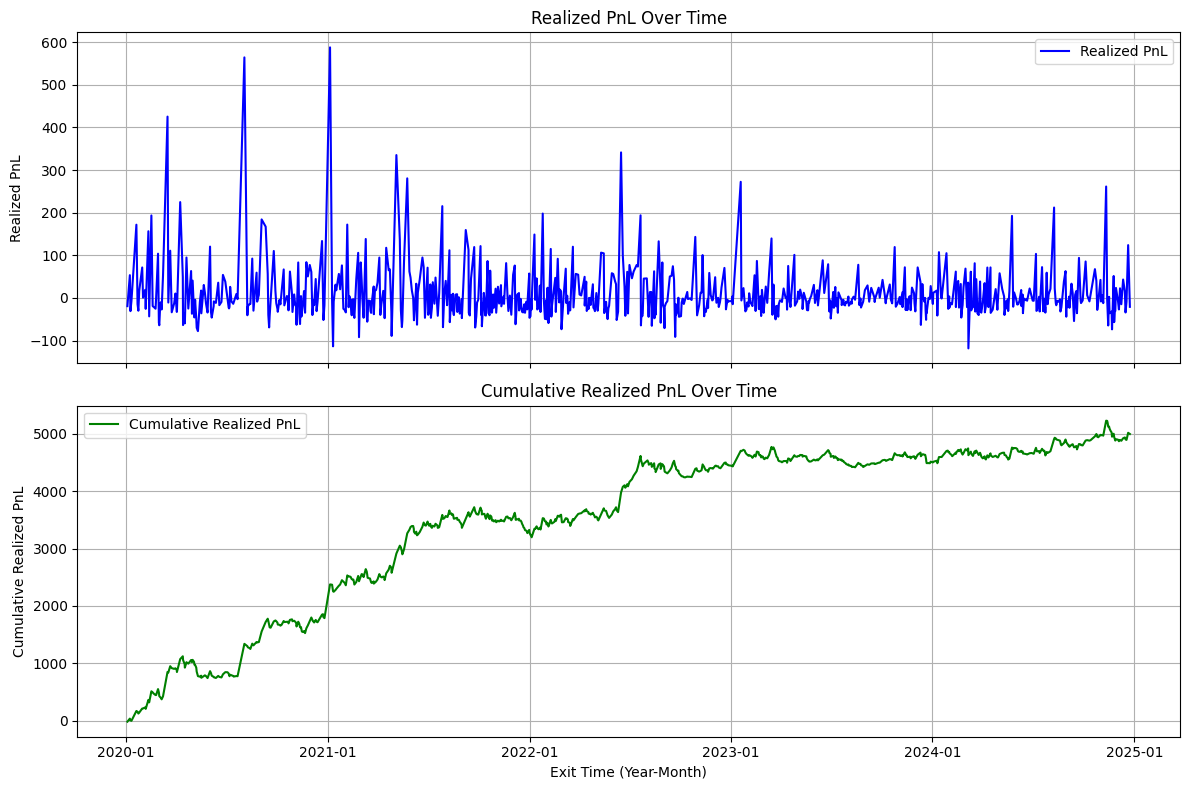

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

backtest_trade_sim_plot = backtest_trade_sim.copy()

# Convert exit_time from UNIX milliseconds to UTC+0 datetime
backtest_trade_sim_plot['exit_time_utc'] = pd.to_datetime(
    backtest_trade_sim_plot['exit_time'], unit='s', utc=True
)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Realized PnL vs Exit Time
ax[0].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['realized_pnl'], label='Realized PnL', color='blue')
ax[0].set_title('Realized PnL Over Time')
ax[0].set_ylabel('Realized PnL')

# Cumulative Realized PnL vs Exit Time
ax[1].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['cumulative_realized_pnl'], label='Cumulative Realized PnL', color='green')
ax[1].set_title('Cumulative Realized PnL Over Time')
ax[1].set_ylabel('Cumulative Realized PnL')

# Format x-axis to show year and month
ax[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
ax[1].set_xlabel('Exit Time (Year-Month)')

# Improve layout and add gridlines
for axis in ax:
    axis.grid(True)
    axis.legend()

plt.tight_layout()
plt.show()